In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tools.eval_measures as      em
from   sklearn.metrics                 import  mean_squared_error
from   statsmodels.tsa.api             import ExponentialSmoothing, SimpleExpSmoothing, Holt
from   IPython.display                 import display
from   pylab                           import rcParams

In [2]:
df = pd.read_csv('C://Users//subra//Downloads//Rose.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   YearMonth  187 non-null    object 
 1   Rose       185 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.1+ KB


#### There are total 187 entries, one is object type and other columns is float. SInce its TS will parse the object column i.e YearMonth to Date.

In [4]:
df.head()

,YearMonth,Rose
0,1980-01,112.0
1,1980-02,118.0
2,1980-03,129.0
3,1980-04,99.0
4,1980-05,116.0


In [5]:
df.tail()

,YearMonth,Rose
182,1995-03,45.0
183,1995-04,52.0
184,1995-05,28.0
185,1995-06,40.0
186,1995-07,62.0


In [6]:
df.shape

(187, 2)

In [7]:
df = pd.read_csv('C://Users//subra//Downloads//Rose.csv', parse_dates=['YearMonth'], index_col='YearMonth')

In [8]:
df.dtypes

Rose    float64
dtype: object

## Check the summary statistics

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rose,185.0,90.394595,39.175344,28.0,63.0,86.0,112.0,267.0


## Observation:
1. The Rose has a min of 28 and max of 267. With median as 89. With the range it looks like it has extreme datapoints so it will have outliers.

## Check for null records

In [10]:
df.isnull().sum()

Rose    2
dtype: int64

There are only two missing values.

## Treat the null values

In [11]:
df['Rose'].unique()

array([112., 118., 129.,  99., 116., 168., 205., 147., 150., 267., 126.,
       124.,  97., 102., 127., 222., 214., 141., 154., 226.,  89.,  77.,
        82., 121., 117., 106., 134., 169.,  75., 108., 115.,  85., 101.,
       109., 105.,  95., 135., 164.,  88.,  87.,  91., 142., 139., 159.,
        61.,  93., 103.,  90., 123.,  57.,  65.,  67.,  71.,  76., 110.,
       107.,  58.,  70.,  86.,  74.,  73., 100.,  96., 157.,  63.,  66.,
        83.,  79.,  60., 137.,  43.,  69.,  78., 132.,  54.,  55.,  34.,
        47.,  56.,  53.,  52.,  46.,  51.,  33.,  40.,  45.,  41.,  48.,
        30.,  35.,  42.,  44.,  nan,  84.,  39.,  28.,  62.])

In [12]:
df['Rose'] = df['Rose'].replace(np.nan, df['Rose'].median())

In [13]:
df.isnull().sum()

Rose    0
dtype: int64

## Check the duplicate records.

In [14]:
df.duplicated().sum()

91

There are total 91 duplicate records.

## Treat the duplicate records.

In [15]:
df = df.drop_duplicates()

In [16]:
df.duplicated().sum()

0

## Univariant analysis

Rose


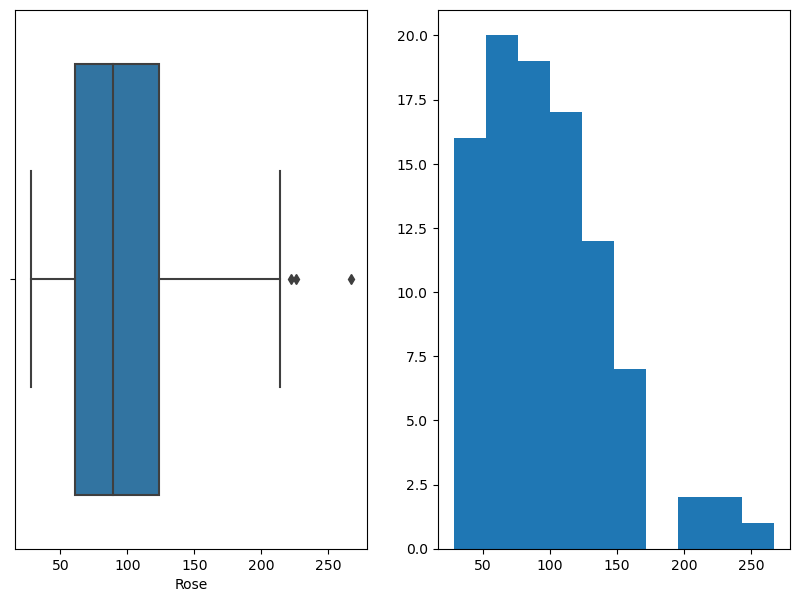

In [17]:
for feature in df.select_dtypes(include='number'):
    print(feature)
    plt.figure(figsize=(10, 7))
    plt.subplot(1,2,1)
    sns.boxplot(x=df[feature])
    plt.subplot(1,2,2)
    plt.hist(x=df[feature])
    
    plt.show()

## Observation
1. Rose has extreme values we can see outliers. Its not evenly distributed. Will treat them with box plot technique.

## Outlier treatment

In [18]:
#Boxplot technique to treat outliers
def remove_outliers(col):
    Q1,Q3=np.percentile(col,[25,75])
    IQR = Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

lower range -33.0 and upper range 217.0


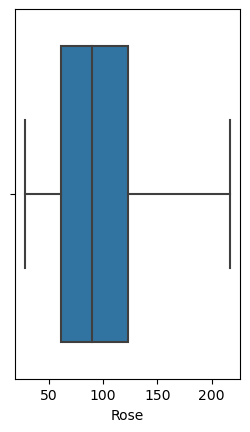

In [19]:
for col in df[1:]:
    lr, ur = remove_outliers(df[col])
    print("lower range",lr, "and upper range", ur)
    df[col] = np.where(df[col]> ur,ur,df[col])
    df[col] = np.where(df[col]<lr,lr,df[col])
    plt.subplot(1,2,1)
    sns.boxplot(x=df[col])
    plt.show()

Outlier datapoints are treated.

## Plot the time series

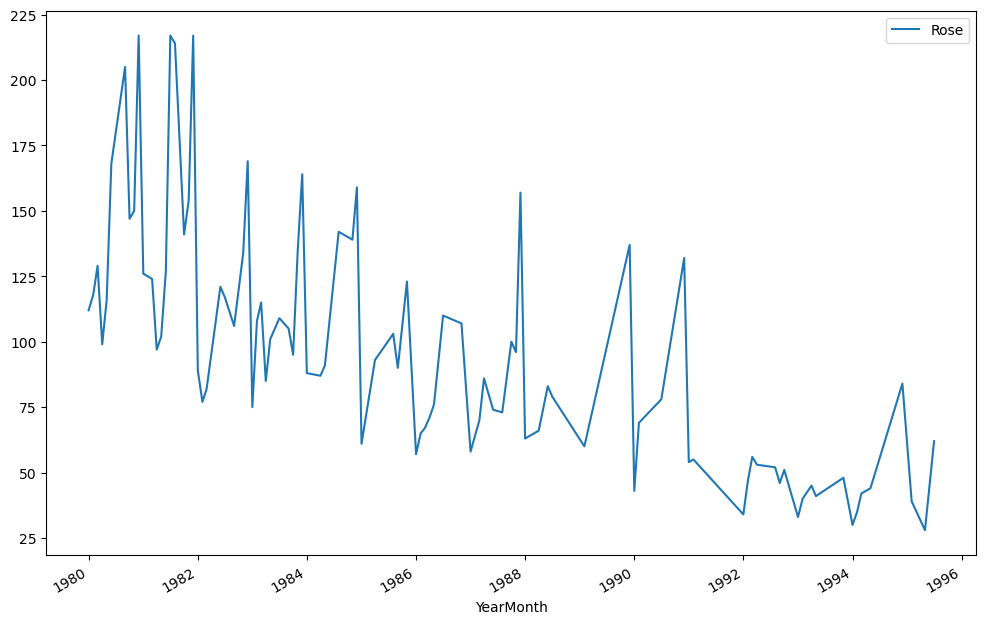

In [20]:
#Increase the figure size
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
df.plot()
plt.show()

We see an decreasing trend and seasonality which is not constant in nature.

## Additive decomposition

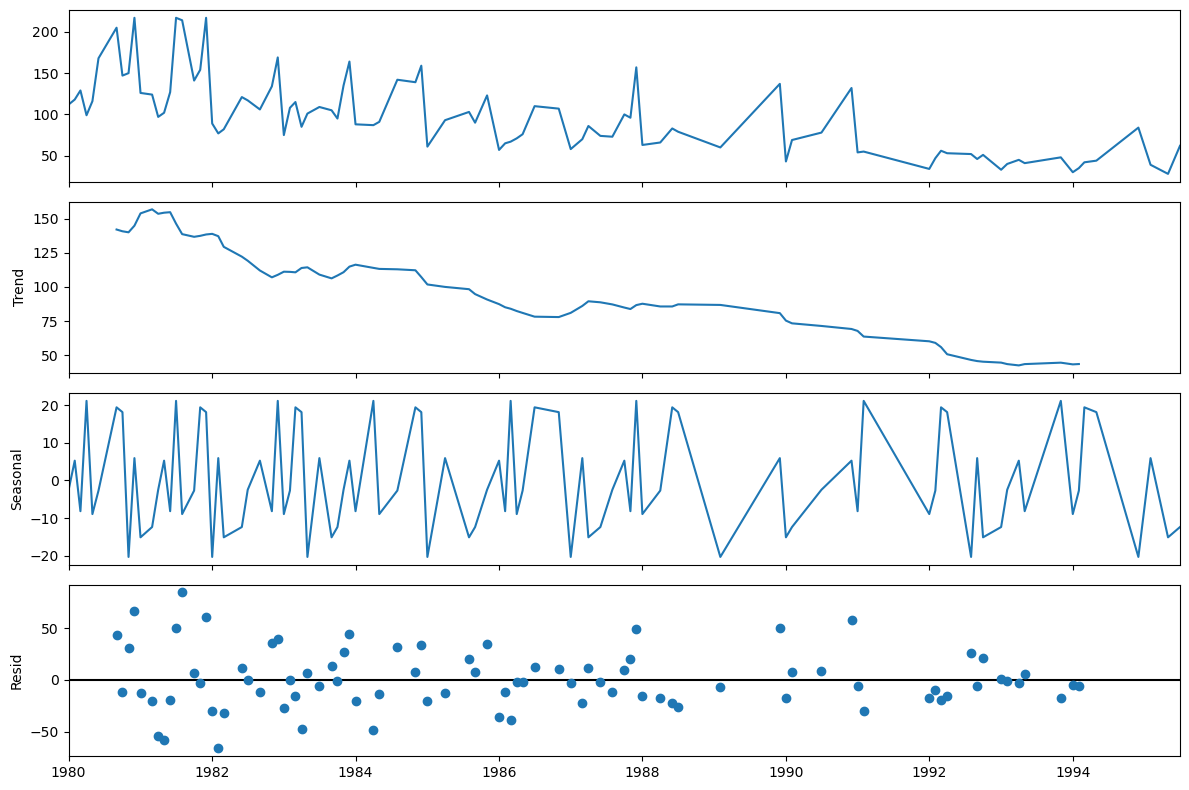

In [21]:
#Decompose the time series additively
df_add_decompose = seasonal_decompose(df, model = 'additive', period = 12)
df_add_decompose.plot()
plt.show()

We see that the residuals are located around 0 from the plot of the residuals in the decomposition.

In [22]:
trend = df_add_decompose.trend
seasonality = df_add_decompose.seasonal
residual = df_add_decompose.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 YearMonth
1980-01-01           NaN
1980-02-01           NaN
1980-03-01           NaN
1980-04-01           NaN
1980-05-01           NaN
1980-06-01           NaN
1980-09-01    141.958333
1980-10-01    140.666667
1980-11-01    139.916667
1980-12-01    144.750000
1981-01-01    153.750000
1981-03-01    156.708333
Name: trend, dtype: float64 

Seasonality 
 YearMonth
1980-01-01    -2.457837
1980-02-01     5.268353
1980-03-01    -8.154266
1980-04-01    21.155258
1980-05-01    -8.916171
1980-06-01    -2.678075
1980-09-01    19.440972
1980-10-01    18.161210
1980-11-01   -20.309028
1980-12-01     5.946925
1981-01-01   -15.094742
1981-03-01   -12.362599
Name: seasonal, dtype: float64 

Residual 
 YearMonth
1980-01-01          NaN
1980-02-01          NaN
1980-03-01          NaN
1980-04-01          NaN
1980-05-01          NaN
1980-06-01          NaN
1980-09-01    43.600694
1980-10-01   -11.827877
1980-11-01    30.392361
1980-12-01    66.303075
1981-01-01   -12.655258
1981-03-01   -20.34573

#### 

## Multiplicative decomposition

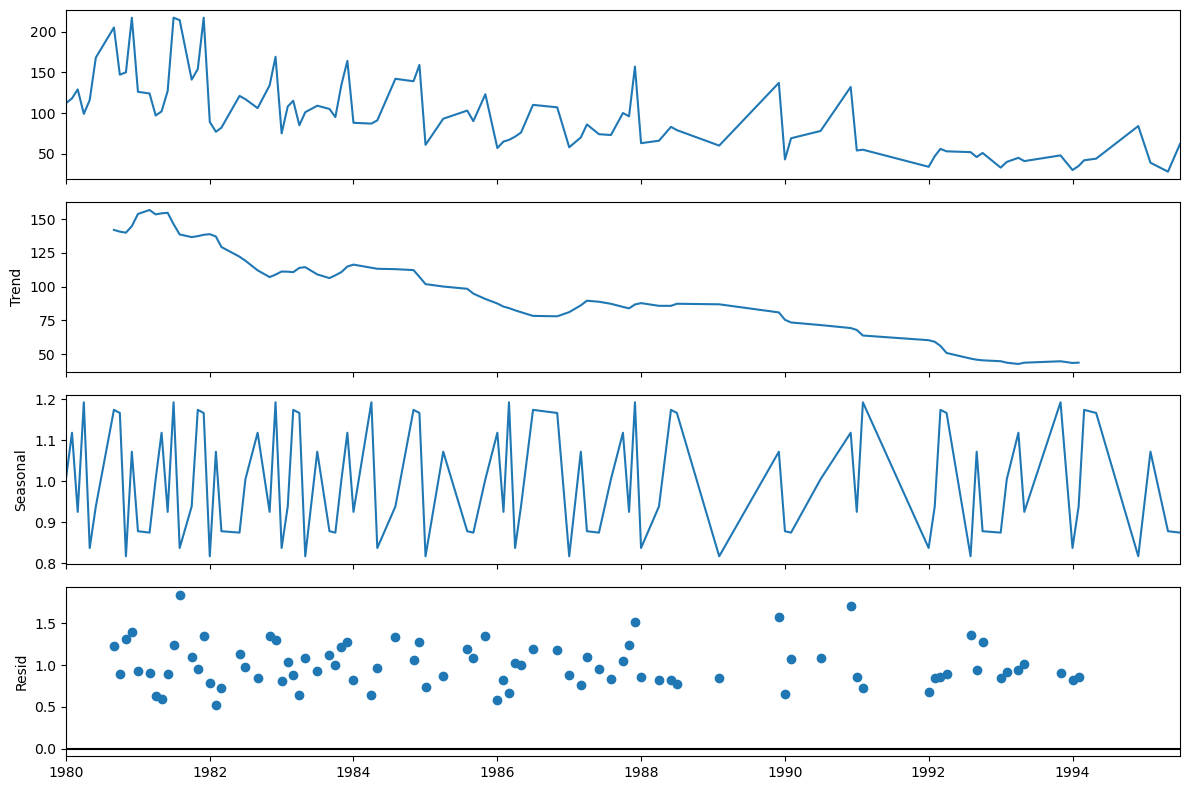

In [23]:
##Decompose the time series multiplicatively
df_mul_decompose = seasonal_decompose(df, model = "multiplicative", period=12)
df_mul_decompose.plot()
plt.show()

For the multiplicative series, we see that a lot of residuals are located around 1. Thus Multiplicative Decomposition is the right way to decompose the time series.

In [24]:
trend = df_mul_decompose.trend
seasonality = df_mul_decompose.seasonal
residual = df_mul_decompose.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 YearMonth
1980-01-01           NaN
1980-02-01           NaN
1980-03-01           NaN
1980-04-01           NaN
1980-05-01           NaN
1980-06-01           NaN
1980-09-01    141.958333
1980-10-01    140.666667
1980-11-01    139.916667
1980-12-01    144.750000
1981-01-01    153.750000
1981-03-01    156.708333
Name: trend, dtype: float64 

Seasonality 
 YearMonth
1980-01-01    1.005084
1980-02-01    1.118391
1980-03-01    0.925328
1980-04-01    1.192655
1980-05-01    0.837201
1980-06-01    0.938609
1980-09-01    1.174200
1980-10-01    1.166623
1980-11-01    0.816985
1980-12-01    1.072100
1981-01-01    0.878124
1981-03-01    0.874700
Name: seasonal, dtype: float64 

Residual 
 YearMonth
1980-01-01         NaN
1980-02-01         NaN
1980-03-01         NaN
1980-04-01         NaN
1980-05-01         NaN
1980-06-01         NaN
1980-09-01    1.229846
1980-10-01    0.895768
1980-11-01    1.312224
1980-12-01    1.398318
1981-01-01    0.933253
1981-03-01    0.904629
Name: resid, dtype: fl

In [25]:
#Let's try to do log transformation
df_log = df.copy()
df_log['Rose'] = np.log(df)
df_log.Rose

YearMonth
1980-01-01    4.718499
1980-02-01    4.770685
1980-03-01    4.859812
1980-04-01    4.595120
1980-05-01    4.753590
                ...   
1994-05-01    3.784190
1994-12-01    4.430817
1995-02-01    3.663562
1995-05-01    3.332205
1995-07-01    4.127134
Name: Rose, Length: 96, dtype: float64

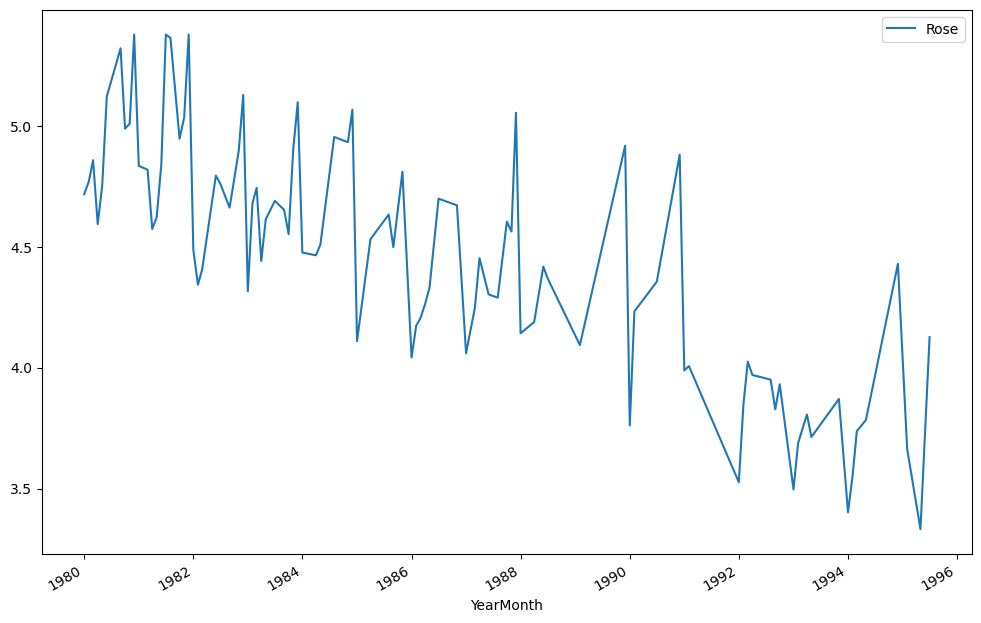

In [26]:
#Visualize the log transformed series
df_log.plot()
plt.show()

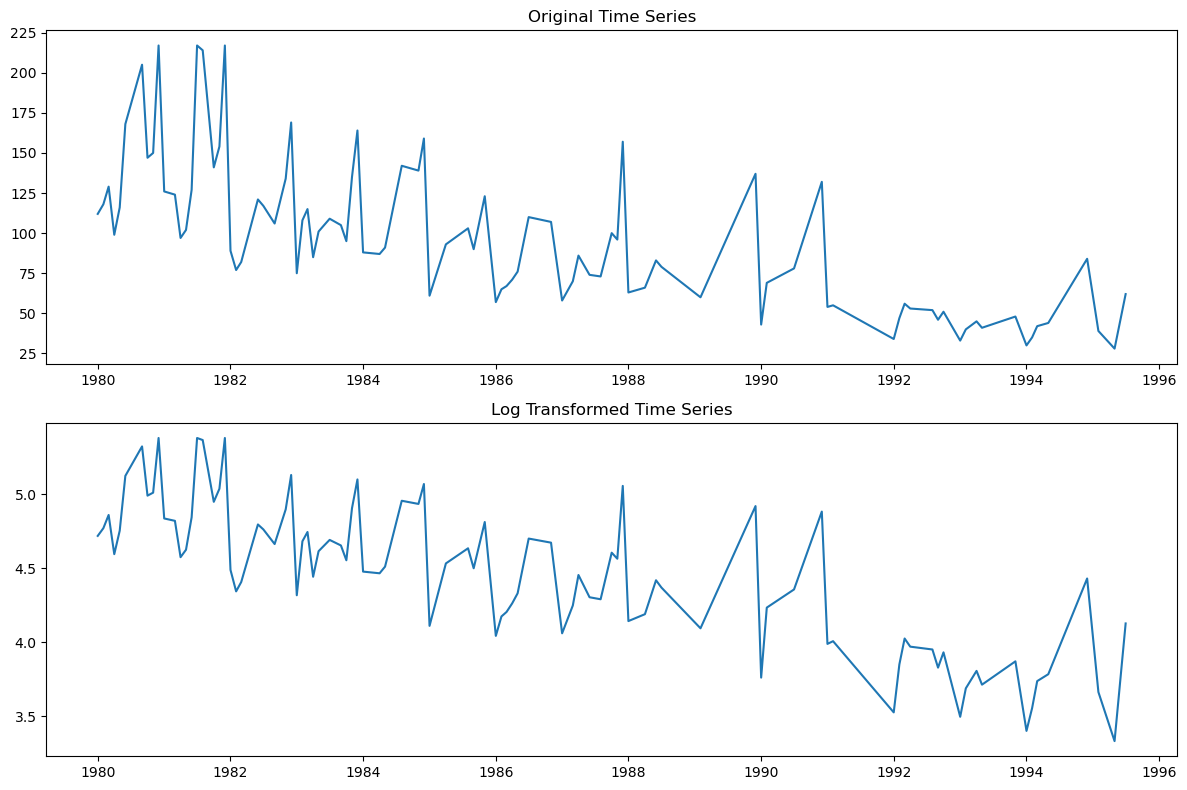

In [27]:
#Compare with the original series
plt.subplot(2,1,1)
plt.title('Original Time Series')
plt.plot(df)

plt.subplot(2,1,2)
plt.title('Log Transformed Time Series')
plt.plot(df_log)
plt.tight_layout()

#### 

## Split the data into train and test and plot the training and test data. [30% of the most recent data will be in the test set]

In [28]:
train    =   df[0:int(len(df)*0.7)] 
test     =   df[int(len(df)*0.7):]

In [29]:
print(train.shape)
print(test.shape)

(67, 1)
(29, 1)


In [30]:
from IPython.display import display
print('First few rows of Training Data')
display(train.head())
print('Last few rows of Training Data')
display(train.tail())
print('First few rows of Test Data')
display(test.head())
print('Last few rows of Test Data')
display(test.tail())

First few rows of Training Data


,Rose
YearMonth,
1980-01-01,112.0
1980-02-01,118.0
1980-03-01,129.0
1980-04-01,99.0
1980-05-01,116.0


Last few rows of Training Data


,Rose
YearMonth,
1987-11-01,96.0
1987-12-01,157.0
1988-01-01,63.0
1988-04-01,66.0
1988-06-01,83.0


First few rows of Test Data


,Rose
YearMonth,
1988-07-01,79.0
1989-02-01,60.0
1989-12-01,137.0
1990-01-01,43.0
1990-02-01,69.0


Last few rows of Test Data


,Rose
YearMonth,
1994-05-01,44.0
1994-12-01,84.0
1995-02-01,39.0
1995-05-01,28.0
1995-07-01,62.0


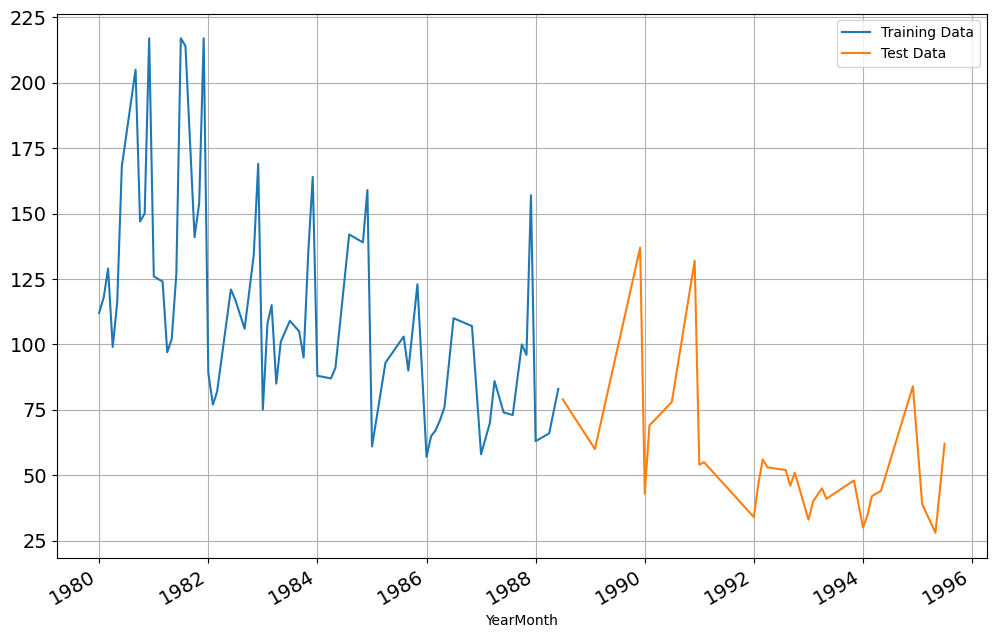

In [31]:
train['Rose'].plot(fontsize=14)
test['Rose'].plot(fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

## Building different models and comparing the accuracy metrics

### Model 1: Linear Regression

In [32]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+68 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
Test Time instance 
 [68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]


We see that we have successfully the generated the numerical time instance order for both the training and test set. Now we will add these values in the training and test set.

In [33]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [34]:
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

print('First few rows of Training Data')
display(LinearRegression_train.head())
print('Last few rows of Training Data')
display(LinearRegression_train.tail())
print('First few rows of Test Data')
display(LinearRegression_test.head())
print('Last few rows of Test Data')
display(LinearRegression_test.tail())

First few rows of Training Data


,Rose,time
YearMonth,,
1980-01-01,112.0,1
1980-02-01,118.0,2
1980-03-01,129.0,3
1980-04-01,99.0,4
1980-05-01,116.0,5


Last few rows of Training Data


,Rose,time
YearMonth,,
1987-11-01,96.0,63
1987-12-01,157.0,64
1988-01-01,63.0,65
1988-04-01,66.0,66
1988-06-01,83.0,67


First few rows of Test Data


,Rose,time
YearMonth,,
1988-07-01,79.0,68
1989-02-01,60.0,69
1989-12-01,137.0,70
1990-01-01,43.0,71
1990-02-01,69.0,72


Last few rows of Test Data


,Rose,time
YearMonth,,
1994-05-01,44.0,92
1994-12-01,84.0,93
1995-02-01,39.0,94
1995-05-01,28.0,95
1995-07-01,62.0,96


Our training and test data has been modified, now will use  Linearregressionto build the model on the training data and test the model on the test data.

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
lr = LinearRegression()

In [37]:
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Rose'])

LinearRegression()

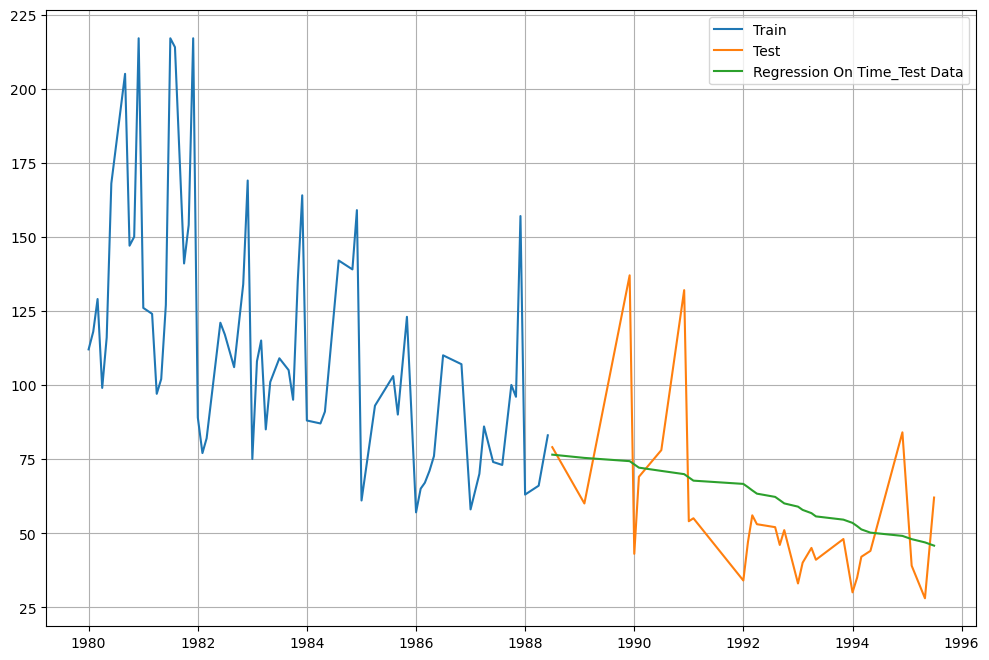

In [38]:
train_predictions_model1         = lr.predict(LinearRegression_train[['time']])
LinearRegression_train['RegOnTime'] = train_predictions_model1

test_predictions_model1         = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime'] = test_predictions_model1

plt.plot( train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')

plt.legend(loc='best')
plt.grid();

### Defining the functions for calculating the accuracy metrics.

In [39]:
from sklearn import metrics

In [40]:
rmse_model1_test = metrics.mean_squared_error(test['Rose'],test_predictions_model1,squared=False)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f " %(rmse_model1_test))

For RegressionOnTime forecast on the Test Data,  RMSE is 23.238 


In [41]:
resultsDf = pd.DataFrame({'Test RMSE': [rmse_model1_test]},index=['RegressionOnTime'])
resultsDf

,Test RMSE
RegressionOnTime,23.237925


## Model 2: Naive Approach

In [42]:
NaiveModel_train = train.copy()
NaiveModel_test = test.copy()

In [43]:
train.tail()

,Rose
YearMonth,
1987-11-01,96.0
1987-12-01,157.0
1988-01-01,63.0
1988-04-01,66.0
1988-06-01,83.0


In [44]:
NaiveModel_test['naive'] = np.asarray(train['Rose'])[len(np.asarray(train['Rose']))-1]
NaiveModel_test['naive'].head()

YearMonth
1988-07-01    83.0
1989-02-01    83.0
1989-12-01    83.0
1990-01-01    83.0
1990-02-01    83.0
Name: naive, dtype: float64

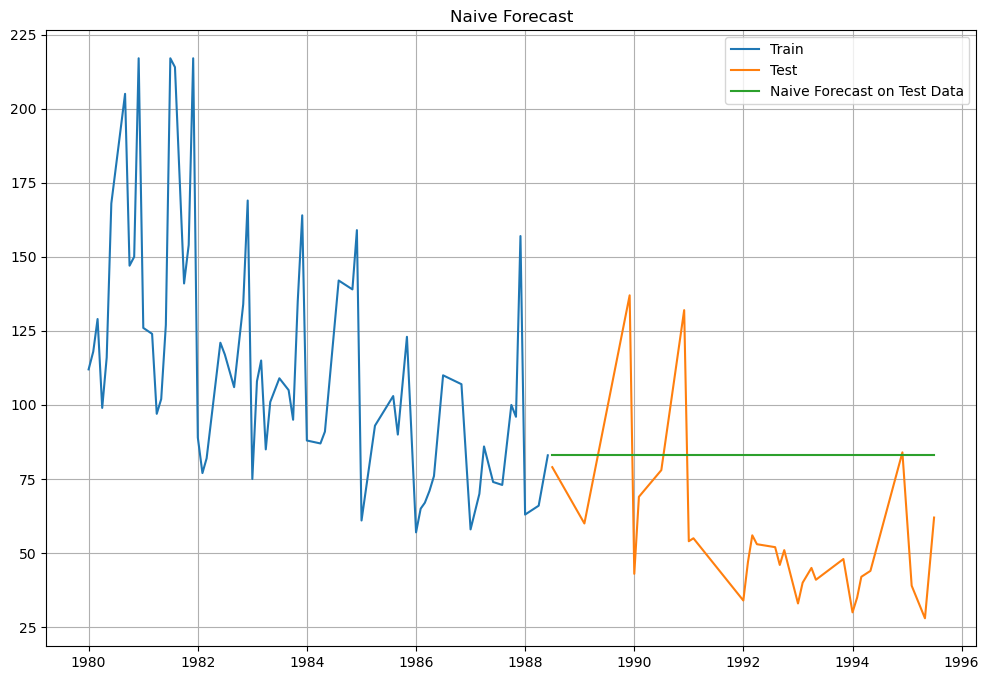

In [45]:
plt.plot(NaiveModel_train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')

plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')

plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid();

### Model Evaluation

In [46]:
rmse_model2_test = metrics.mean_squared_error(test['Rose'],NaiveModel_test['naive'],squared=False)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f" %(rmse_model2_test))

For RegressionOnTime forecast on the Test Data,  RMSE is 37.365


In [47]:
resultsDf_2 = pd.DataFrame({'Test RMSE': [rmse_model2_test]},index=['NaiveModel'])

resultsDf = pd.concat([resultsDf, resultsDf_2])
resultsDf

,Test RMSE
RegressionOnTime,23.237925
NaiveModel,37.364929


## Method 3: Simple Average

In [48]:
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

In [49]:
SimpleAverage_test['mean_forecast'] = train['Rose'].mean()
SimpleAverage_test.head()

,Rose,mean_forecast
YearMonth,,
1988-07-01,79.0,113.761194
1989-02-01,60.0,113.761194
1989-12-01,137.0,113.761194
1990-01-01,43.0,113.761194
1990-02-01,69.0,113.761194


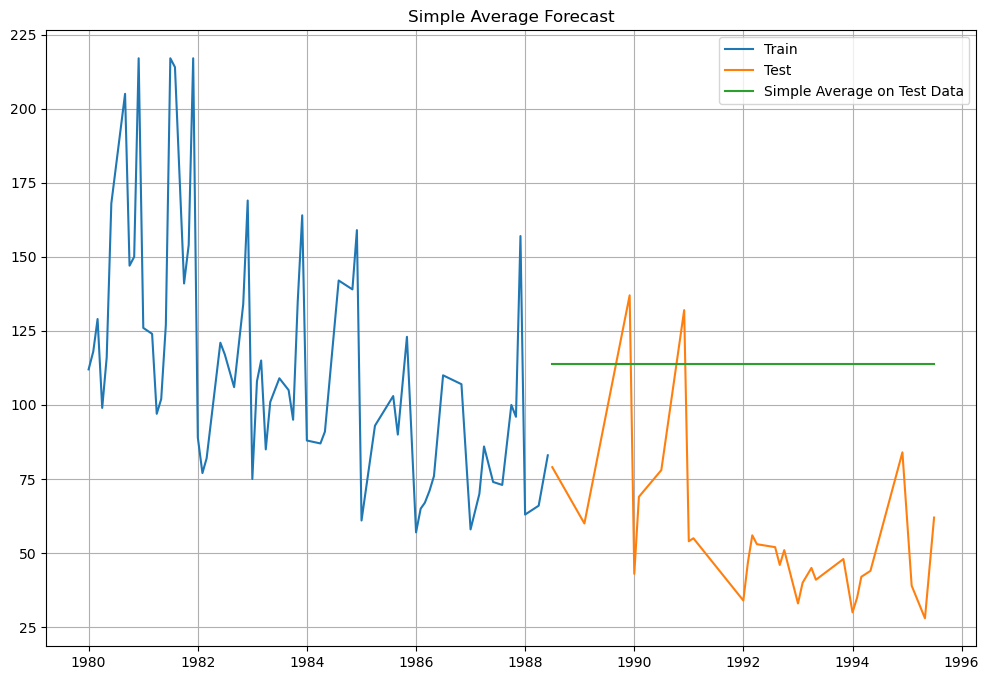

In [50]:
plt.plot(SimpleAverage_train['Rose'], label='Train')
plt.plot(SimpleAverage_test['Rose'], label='Test')

plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')

plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

### Model Evaluation

In [51]:
rmse_model3_test = metrics.mean_squared_error(test['Rose'],SimpleAverage_test['mean_forecast'],squared=False)
print("For Simple Average forecast on the Test Data,  RMSE is %3.3f" %(rmse_model3_test))

For Simple Average forecast on the Test Data,  RMSE is 63.390


In [52]:
resultsDf_3 = pd.DataFrame({'Test RMSE': [rmse_model3_test]}
                           ,index=['SimpleAverageModel'])

resultsDf = pd.concat([resultsDf, resultsDf_3])
resultsDf

,Test RMSE
RegressionOnTime,23.237925
NaiveModel,37.364929
SimpleAverageModel,63.390407


## Method 4: Moving Average(MA)

In [53]:
MovingAverage = df.copy()
MovingAverage.head()

,Rose
YearMonth,
1980-01-01,112.0
1980-02-01,118.0
1980-03-01,129.0
1980-04-01,99.0
1980-05-01,116.0


In [54]:

MovingAverage['Trailing_2'] = MovingAverage['Rose'].rolling(2).mean()
MovingAverage['Trailing_4'] = MovingAverage['Rose'].rolling(4).mean()
MovingAverage['Trailing_6'] = MovingAverage['Rose'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['Rose'].rolling(9).mean()

MovingAverage.head()

,Rose,Trailing_2,Trailing_4,Trailing_6,Trailing_9
YearMonth,,,,,
1980-01-01,112.0,NaN,NaN,NaN,NaN
1980-02-01,118.0,115.0,NaN,NaN,NaN
1980-03-01,129.0,123.5,NaN,NaN,NaN
1980-04-01,99.0,114.0,114.5,NaN,NaN
1980-05-01,116.0,107.5,115.5,NaN,NaN


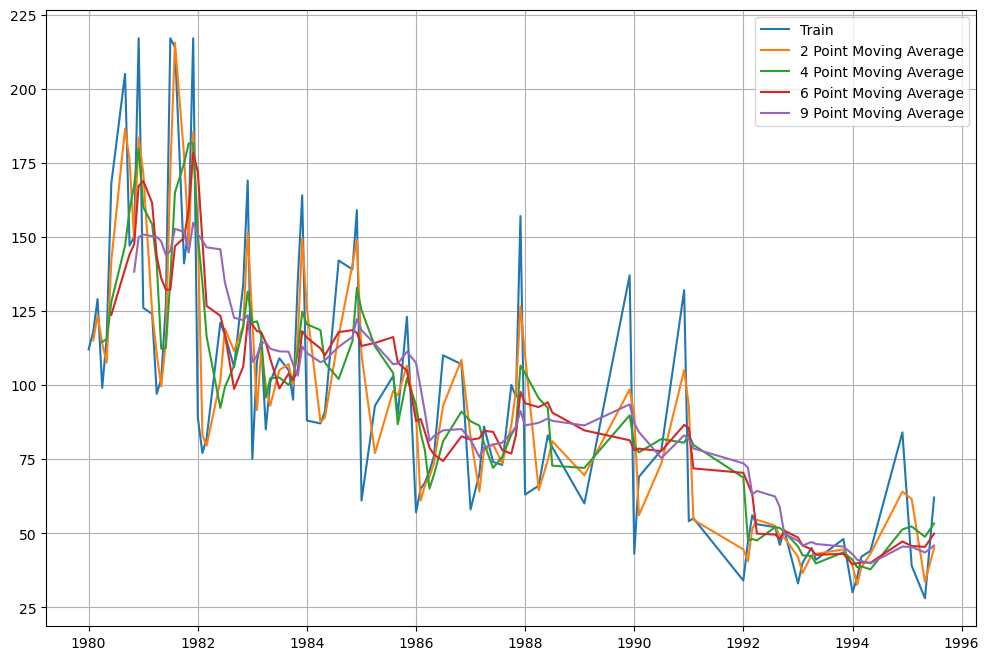

In [55]:
## Plotting on the whole data

plt.plot(MovingAverage['Rose'], label='Train')
plt.plot(MovingAverage['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage['Trailing_6'],label = '6 Point Moving Average')
plt.plot(MovingAverage['Trailing_9'],label = '9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

In [56]:
#Creating train and test set 
trailing_MovingAverage_train=MovingAverage[0:int(len(MovingAverage)*0.7)] 
trailing_MovingAverage_test=MovingAverage[int(len(MovingAverage)*0.7):]

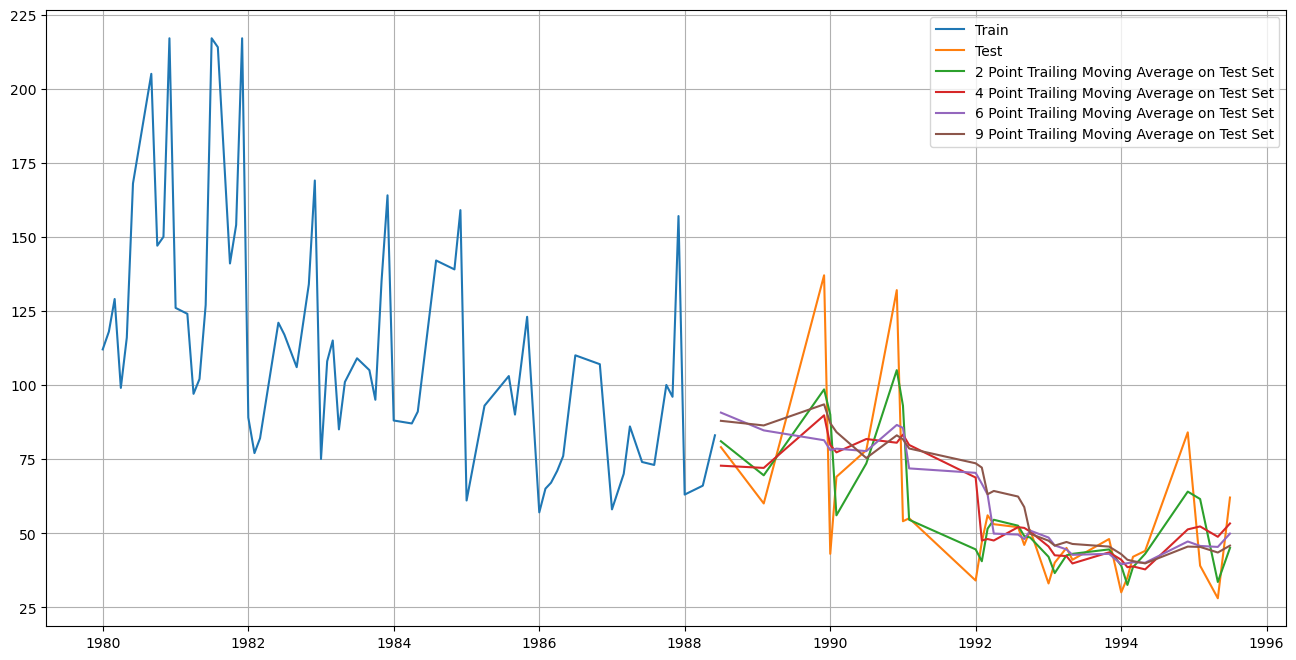

In [57]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(trailing_MovingAverage_train['Rose'], label='Train')
plt.plot(trailing_MovingAverage_test['Rose'], label='Test')


plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_6'],label = '6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_9'],label = '9 Point Trailing Moving Average on Test Set')

plt.legend(loc = 'best')
plt.grid();

### Model Evaluation

In [58]:
## Test Data - RMSE  --> 2 point Trailing MA

rmse_model4_test_2 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_2'],squared=False)
print("For 2 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_2))

## Test Data - RMSE --> 4 point Trailing MA

rmse_model4_test_4 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_4'],squared=False)
print("For 4 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_4))

## Test Data - RMSE --> 6 point Trailing MA

rmse_model4_test_6 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_6'],squared=False)
print("For 6 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_6))

## Test Data - RMSE --> 9 point Trailing MA

rmse_model4_test_9 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_9'],squared=False)
print("For 9 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_9))

For 2 point Moving Average Model forecast on the Training Data,  RMSE is 16.460
For 4 point Moving Average Model forecast on the Training Data,  RMSE is 19.856
For 6 point Moving Average Model forecast on the Training Data,  RMSE is 20.816
For 9 point Moving Average Model forecast on the Training Data,  RMSE is 21.772


In [59]:
resultsDf_4 = pd.DataFrame({'Test RMSE': [rmse_model4_test_2,rmse_model4_test_4
                                          ,rmse_model4_test_6,rmse_model4_test_9]}
                           ,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])

resultsDf = pd.concat([resultsDf, resultsDf_4])
resultsDf

,Test RMSE
RegressionOnTime,23.237925
NaiveModel,37.364929
SimpleAverageModel,63.390407
2pointTrailingMovingAverage,16.460245
4pointTrailingMovingAverage,19.856435
6pointTrailingMovingAverage,20.815809
9pointTrailingMovingAverage,21.772118


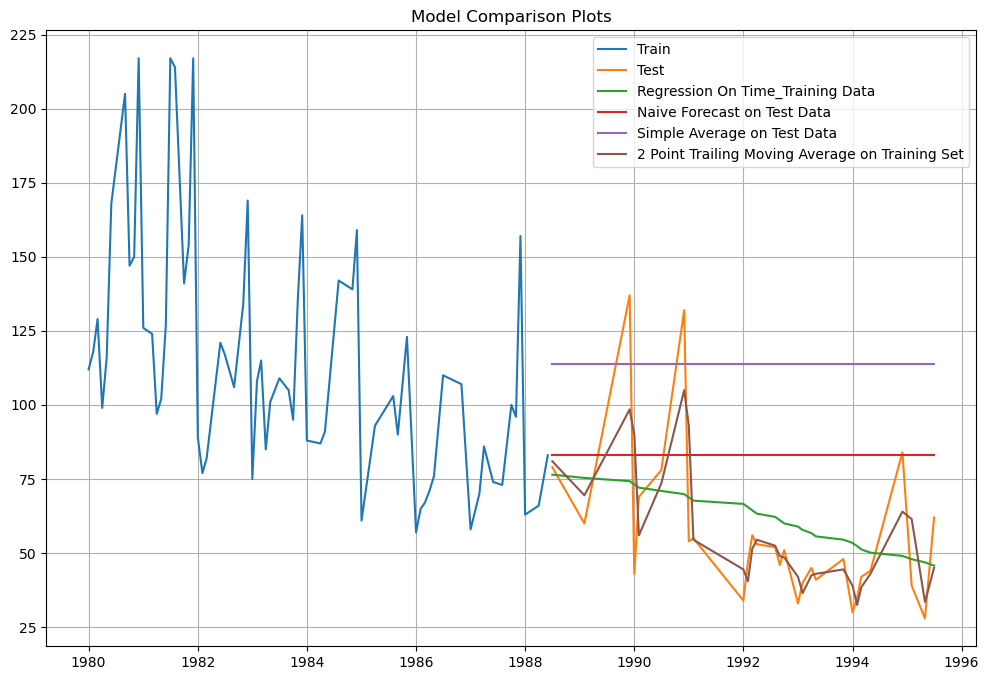

In [60]:
## Plotting on both Training and Test data

plt.plot(train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')

plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Training Data')

plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')

plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')

plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')


plt.legend(loc='best')
plt.title("Model Comparison Plots")
plt.grid();

### SES - ETS(A, N, N) - Simple Exponential Smoothing with additive errors

In [61]:
df.head()

,Rose
YearMonth,
1980-01-01,112.0
1980-02-01,118.0
1980-03-01,129.0
1980-04-01,99.0
1980-05-01,116.0


In [62]:
# create class
model_SES = SimpleExpSmoothing(train,initialization_method='estimated')

C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [63]:
# Fitting the Simple Exponential Smoothing model and asking python to choose the optimal parameters
model_SES_autofit = model_SES.fit(optimized=True)

In [64]:
## Let us check the parameters

model_SES_autofit.params

{'smoothing_level': 0.15045746473027144,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 133.50451788578772,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [65]:
# Using the fitted model on the training set to forecast on the test set
SES_predict = model_SES_autofit.forecast(steps=len(test))
SES_predict

C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


67    87.173033
68    87.173033
69    87.173033
70    87.173033
71    87.173033
72    87.173033
73    87.173033
74    87.173033
75    87.173033
76    87.173033
77    87.173033
78    87.173033
79    87.173033
80    87.173033
81    87.173033
82    87.173033
83    87.173033
84    87.173033
85    87.173033
86    87.173033
87    87.173033
88    87.173033
89    87.173033
90    87.173033
91    87.173033
92    87.173033
93    87.173033
94    87.173033
95    87.173033
dtype: float64

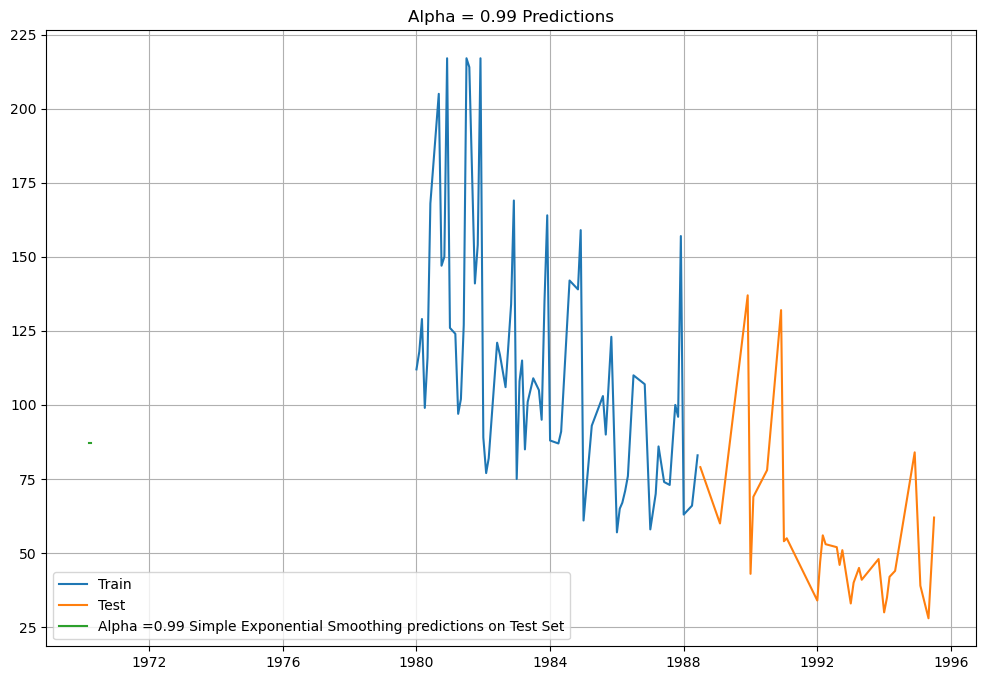

In [66]:
## Plotting the Training data, Test data and the forecasted values

plt.plot(train, label='Train')
plt.plot(test, label='Test')

plt.plot(SES_predict, label='Alpha =0.99 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.99 Predictions');

In [67]:
## Mean Absolute Percentage Error (MAPE) - Function Definition

def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [68]:
print('SES RMSE:',mean_squared_error(test.values,SES_predict.values,squared=False))
#different way to calculate RMSE
print('SES RMSE (calculated using statsmodels):',em.rmse(test.values,SES_predict.values)[0])

SES RMSE: 40.50815318862627
SES RMSE (calculated using statsmodels): 40.50815318862627


In [69]:
resultsDf = pd.DataFrame({'Test RMSE': [em.rmse(test.values,SES_predict.values)[0]]},index=['Alpha=0.99,SES'])
resultsDf

,Test RMSE
"Alpha=0.99,SES",40.508153


### Double Exponential Smoothing

In [70]:
# Initializing the Double Exponential Smoothing Model
model_DES = Holt(train,initialization_method='estimated')
# Fitting the model
model_DES = model_DES.fit()

print('')
print('==Holt model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_DES.params)


==Holt model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 1.4901161193847656e-08, 'smoothing_trend': 6.50930364685497e-10, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 151.04883630762092, 'initial_trend': -1.0966954405321632, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [71]:
# Forecasting using this model for the duration of the test set
DES_predict =  model_DES.forecast(len(test))
DES_predict

C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


67    76.473546
68    75.376851
69    74.280155
70    73.183460
71    72.086765
72    70.990069
73    69.893374
74    68.796678
75    67.699983
76    66.603287
77    65.506592
78    64.409897
79    63.313201
80    62.216506
81    61.119810
82    60.023115
83    58.926419
84    57.829724
85    56.733028
86    55.636333
87    54.539638
88    53.442942
89    52.346247
90    51.249551
91    50.152856
92    49.056160
93    47.959465
94    46.862769
95    45.766074
dtype: float64

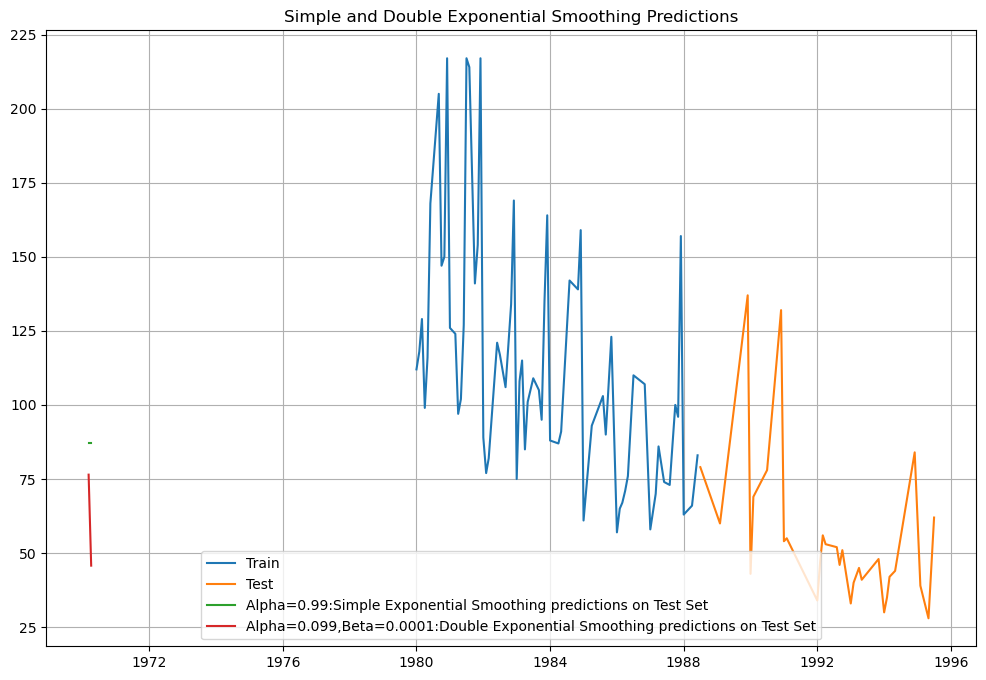

In [72]:
## Plotting the Training data, Test data and the forecasted values

plt.plot(train, label='Train')
plt.plot(test, label='Test')

plt.plot(SES_predict, label='Alpha=0.99:Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict, label='Alpha=0.099,Beta=0.0001:Double Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Simple and Double Exponential Smoothing Predictions');

In [73]:
print('DES RMSE:',mean_squared_error(test.values,DES_predict.values,squared=False))

DES RMSE: 23.237927193327806


In [74]:
resultsDf_temp = pd.DataFrame({'Test RMSE': [mean_squared_error(test.values,DES_predict.values,squared=False)]}
                           ,index=['Alpha=1,Beta=0.0189:DES'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,Test RMSE
"Alpha=0.99,SES",40.508153
"Alpha=1,Beta=0.0189:DES",23.237927


### Inference
Here, we see that the Double Exponential Smoothing has actually done well when compared to the Simple Exponential Smoothing. This is because of the fact that the Double Exponential Smoothing model has picked up the trend component as well.

### Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

In [75]:
# Initializing the Double Exponential Smoothing Model
model_TES = ExponentialSmoothing(train,trend='additive',initialization_method='estimated', seasonal='additive',seasonal_periods=12)
# Fitting the model
model_TES = model_TES.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_TES.params)


==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.00014696362553462584, 'smoothing_trend': 1.1086121995684611e-18, 'smoothing_seasonal': 0.00014793563856080517, 'damping_trend': nan, 'initial_level': 151.37210125231258, 'initial_trend': -1.1333364497461949, 'initial_seasons': array([-6.36680111e+00, -6.94061279e+00, -7.24538986e+00,  1.98615912e+01,
       -6.86039764e+00,  6.01609155e+00,  2.45709116e+01,  2.83989446e+01,
       -2.17242008e+01,  2.50706823e-02, -9.81322052e+00, -9.26340367e+00]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [76]:
# Forecasting using this model for the duration of the test set
TES_predict =  model_TES.forecast(len(test))
TES_predict

C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


67    102.701685
68     51.445244
69     72.061757
70     61.088782
71     60.505988
72     62.269305
73     60.562192
74     59.124169
75     85.097986
76     57.242824
77     68.986056
78     86.410126
79     89.101648
80     37.845206
81     58.461720
82     47.488745
83     46.905951
84     48.669267
85     46.962154
86     45.524131
87     71.497949
88     43.642786
89     55.386019
90     72.810088
91     75.501610
92     24.245169
93     44.861682
94     33.888707
95     33.305913
dtype: float64

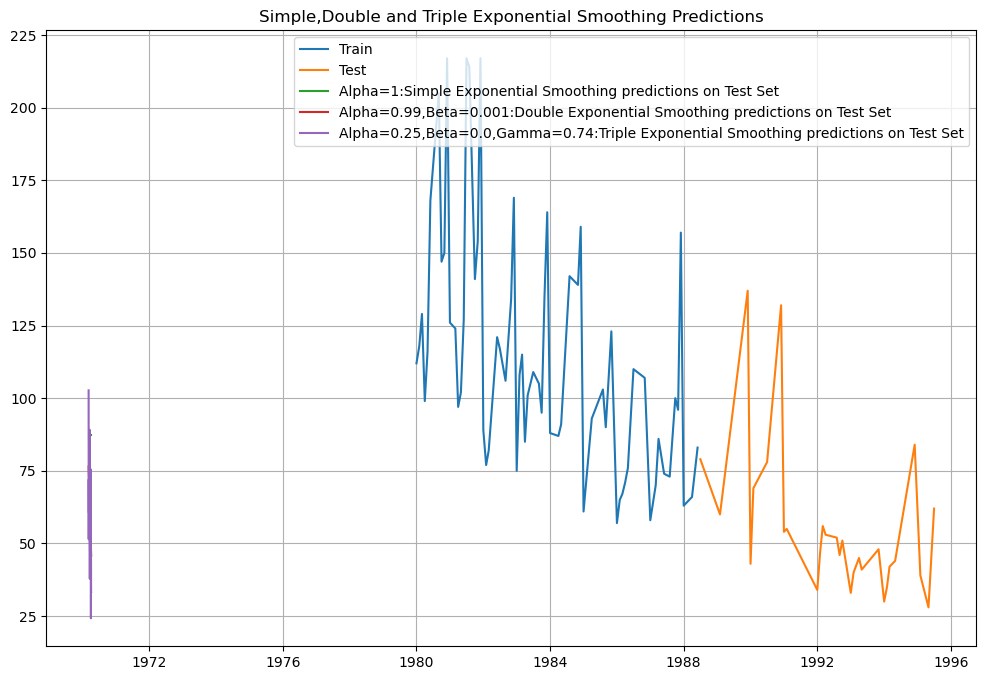

In [77]:
## Plotting the Training data, Test data and the forecasted values

plt.plot(train, label='Train')
plt.plot(test, label='Test')

plt.plot(SES_predict, label='Alpha=1:Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict, label='Alpha=0.99,Beta=0.001:Double Exponential Smoothing predictions on Test Set')
plt.plot(TES_predict, label='Alpha=0.25,Beta=0.0,Gamma=0.74:Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Simple,Double and Triple Exponential Smoothing Predictions');

In [78]:
print('TES RMSE:',mean_squared_error(test.values,TES_predict.values,squared=False))

TES RMSE: 28.165338483308606


In [79]:
resultsDf_temp = pd.DataFrame({'Test RMSE': [mean_squared_error(test.values,TES_predict.values,squared=False)]}
                           ,index=['Alpha=0.25,Beta=0.0,Gamma=0.74:TES'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,Test RMSE
"Alpha=0.99,SES",40.508153
"Alpha=1,Beta=0.0189:DES",23.237927
"Alpha=0.25,Beta=0.0,Gamma=0.74:TES",28.165338


## Inference
Triple Exponential Smoothing has performed the best on the test as expected since the data had both trend and seasonality.

But we see that our triple exponential smoothing is under forecasting. Let us try to tweak some of the parameters in order to get a better forecast on the test set.

## Holt-Winters - ETS(A, A, M) - Holt Winter's linear method

In [80]:
# Initializing the Double Exponential Smoothing Model
model_TES_am = ExponentialSmoothing(train,trend='add',seasonal='multiplicative',initialization_method='estimated',seasonal_periods=12)
# Fitting the model
model_TES_am = model_TES_am.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_TES_am.params)


==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.09304259518400529, 'smoothing_trend': 0.011689340069430185, 'smoothing_seasonal': 0.005403332786925664, 'damping_trend': nan, 'initial_level': 133.86654415015923, 'initial_trend': -0.9570828500360492, 'initial_seasons': array([1.00921858, 1.0002345 , 1.01728976, 1.27516275, 1.06236976,
       1.15820383, 1.33628262, 1.38037323, 0.87151987, 1.10425337,
       0.95589742, 0.99195217]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [81]:
# Forecasting using this model for the duration of the test set
TES_predict_am =  model_TES_am.forecast(len(test))
TES_predict_am

C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


67    96.949073
68    60.408011
69    75.444065
70    64.532864
71    65.925400
72    66.220157
73    64.682056
74    64.712685
75    79.950387
76    65.398650
77    70.299399
78    79.938659
79    81.170342
80    50.441263
81    62.822981
82    53.584492
83    54.580381
84    54.658612
85    53.222320
86    53.075712
87    65.354566
88    53.274966
89    57.062722
90    64.647067
91    65.391611
92    40.474515
93    50.201898
94    42.636120
95    43.235361
dtype: float64

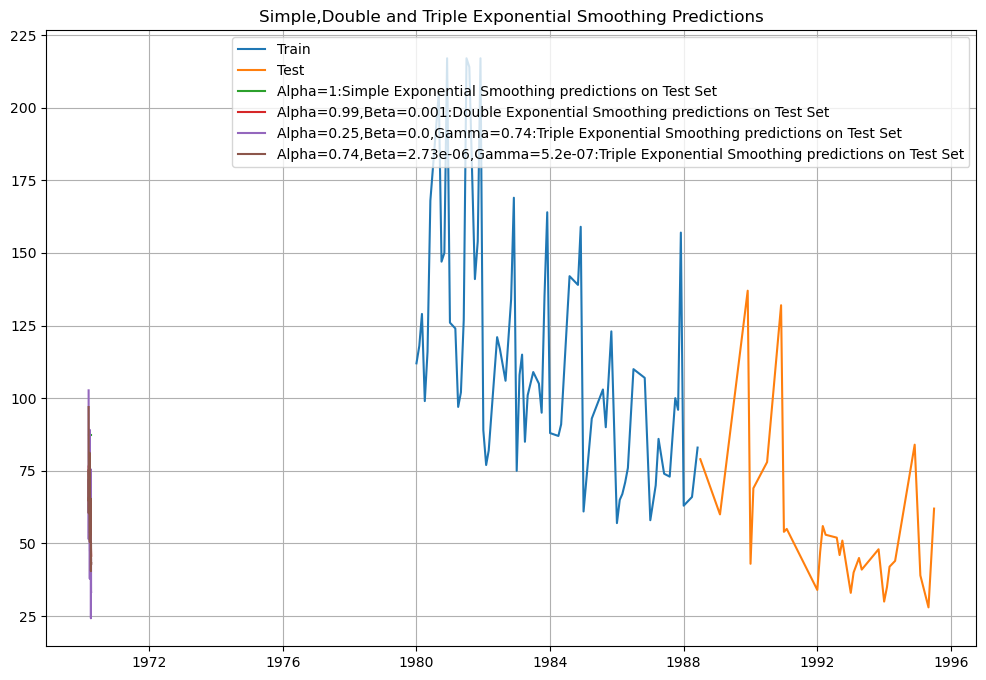

In [82]:
## Plotting the Training data, Test data and the forecasted values

plt.plot(train, label='Train')
plt.plot(test, label='Test')

plt.plot(SES_predict, label='Alpha=1:Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict, label='Alpha=0.99,Beta=0.001:Double Exponential Smoothing predictions on Test Set')
plt.plot(TES_predict, label='Alpha=0.25,Beta=0.0,Gamma=0.74:Triple Exponential Smoothing predictions on Test Set')
plt.plot(TES_predict_am, label='Alpha=0.74,Beta=2.73e-06,Gamma=5.2e-07:Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Simple,Double and Triple Exponential Smoothing Predictions');

In [83]:
print('TES_am RMSE:',mean_squared_error(test.values,TES_predict_am.values,squared=False))

TES_am RMSE: 25.569567787178205


In [84]:
resultsDf_temp = pd.DataFrame({'Test RMSE': [mean_squared_error(test.values,TES_predict_am.values,squared=False)]}
                           ,index=['Alpha=0.74,Beta=2.73e-06,Gamma=5.2e-07,Gamma=0:TES'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,Test RMSE
"Alpha=0.99,SES",40.508153
"Alpha=1,Beta=0.0189:DES",23.237927
"Alpha=0.25,Beta=0.0,Gamma=0.74:TES",28.165338
"Alpha=0.74,Beta=2.73e-06,Gamma=5.2e-07,Gamma=0:TES",25.569568


We see that the multiplicative seasonality model has done well when compared to the additive seasonality Triple Exponential Smoothing model.
But still double soothing model is  better.

## Check for Stationarity

In [141]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df)#python implementation of dicky fuller test 
dftest
print('DF statistic is %3.3f' %dftest[0])
print('DF p-value is %1.4f' %dftest[1])

DF statistic is -0.958
DF p-value is 0.7681


The p-value 0.7681 is very large, and not smaller than 0.05 and thus is not a stationary series. 

Let us take a difference of order 1 and check whether the Time Series is stationary or not.

In [142]:
# Seasonal differencing (assuming monthly data with yearly seasonality)
df = df.diff(periods=12).dropna()

# ADF test for seasonal differencing
(df, "Seasonally Differenced Time Series")


(             Rose
 YearMonth        
 1981-04-01  -15.0
 1981-05-01  -16.0
 1981-06-01   -2.0
 1981-07-01  118.0
 1981-08-01   98.0
 ...           ...
 1994-05-01   -9.0
 1994-12-01   32.0
 1995-02-01   -7.0
 1995-05-01  -23.0
 1995-07-01   29.0
 
 [84 rows x 1 columns],
 'Seasonally Differenced Time Series')

In [143]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df)#python implementation of dicky fuller test 
dftest
print('DF statistic is %3.3f' %dftest[0])
print('DF p-value is %1.4f' %dftest[1])

DF statistic is -3.893
DF p-value is 0.0021


Now its stationary

### Plot the Autocorrelation function plots on the whole data.

In [144]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

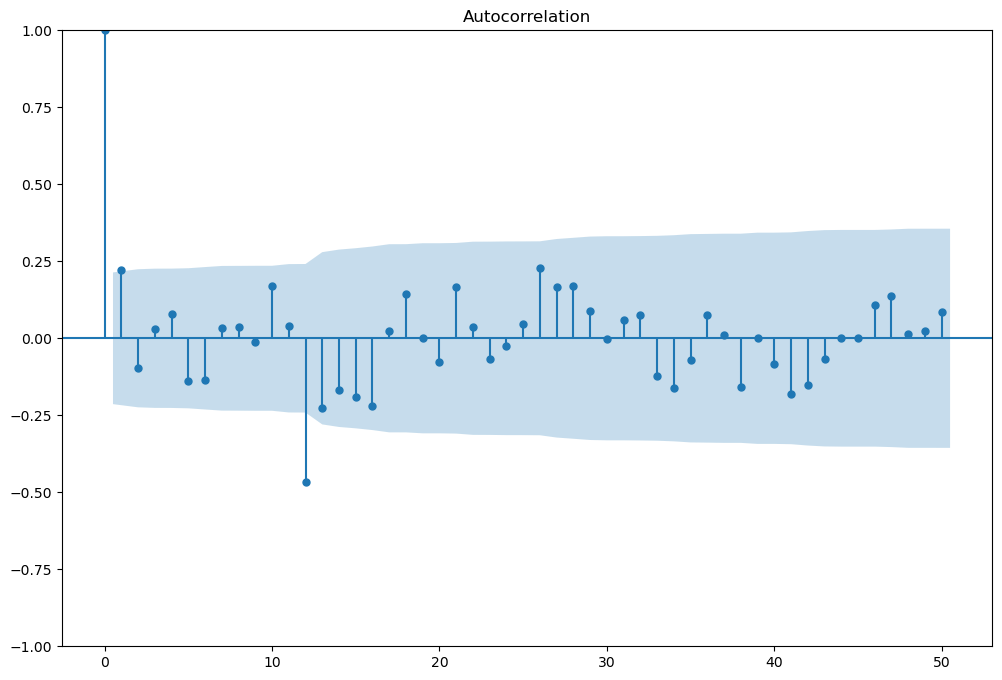

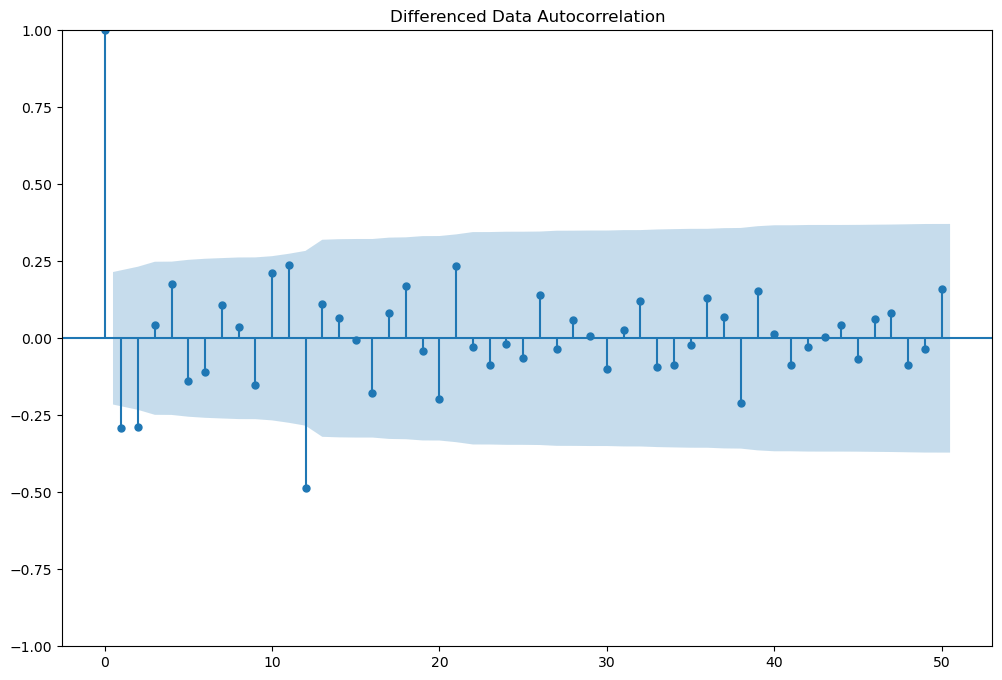

In [145]:
plot_acf(df['Rose'],lags=50)
plot_acf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()

In [146]:
print(train.shape)
print(test.shape)

(67, 1)
(29, 1)


In [147]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 1980-01-01 to 1988-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    67 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB


#### Build an Automated version of an ARMA model for which the best parameters are selected in accordance with the lowest Akaike Information Criteria (AIC

In [148]:
## The following loop helps us in getting a combination of different parameters of p and q in the range of 0 and 2
## We have kept the value of d as 0 as we necessary for an ARMA model 

import itertools
p = q = range(0, 3)
d= range(1)
pdq = list(itertools.product(p, d, q))
print('Some parameter combinations for the Model...')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Some parameter combinations for the Model...
Model: (0, 0, 1)
Model: (0, 0, 2)
Model: (1, 0, 0)
Model: (1, 0, 1)
Model: (1, 0, 2)
Model: (2, 0, 0)
Model: (2, 0, 1)
Model: (2, 0, 2)


In [149]:
# Creating an empty Dataframe with column names only
ARMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARMA_AIC

,param,AIC


In [150]:
from statsmodels.tsa.arima.model import ARIMA

for param in pdq:
    ARMA_model = ARIMA(train['Rose'].values,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARMA_model.aic))
    ARMA_AIC = ARMA_AIC.append({'param':param, 'AIC': ARMA_model.aic}, ignore_index=True)

ARIMA(0, 0, 0) - AIC:689.9189480922317
ARIMA(0, 0, 1) - AIC:677.8175964084813
ARIMA(0, 0, 2) - AIC:678.852846777834


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\825564052.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_AIC = ARMA_AIC.append({'param':param, 'AIC': ARMA_model.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\825564052.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_AIC = ARMA_AIC.append({'param':param, 'AIC': ARMA_model.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\825564052.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_AIC = ARMA_AIC.append({'param':param, 'AIC': ARMA_model.aic}, ignore_index=True)


ARIMA(1, 0, 0) - AIC:676.0895348988412
ARIMA(1, 0, 1) - AIC:678.0798415130738


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\825564052.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_AIC = ARMA_AIC.append({'param':param, 'AIC': ARMA_model.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\825564052.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_AIC = ARMA_AIC.append({'param':param, 'AIC': ARMA_model.aic}, ignore_index=True)


ARIMA(1, 0, 2) - AIC:676.3589131042563
ARIMA(2, 0, 0) - AIC:678.087268135057


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\825564052.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_AIC = ARMA_AIC.append({'param':param, 'AIC': ARMA_model.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\825564052.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_AIC = ARMA_AIC.append({'param':param, 'AIC': ARMA_model.aic}, ignore_index=True)
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting paramet

ARIMA(2, 0, 1) - AIC:679.932599441483
ARIMA(2, 0, 2) - AIC:678.2844000700098


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\825564052.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_AIC = ARMA_AIC.append({'param':param, 'AIC': ARMA_model.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\825564052.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_AIC = ARMA_AIC.append({'param':param, 'AIC': ARMA_model.aic}, ignore_index=True)


In [151]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARMA_AIC.sort_values(by='AIC',ascending=True)

,param,AIC
3,"(1, 0, 0)",676.089535
5,"(1, 0, 2)",676.358913
1,"(0, 0, 1)",677.817596
4,"(1, 0, 1)",678.079842
6,"(2, 0, 0)",678.087268
8,"(2, 0, 2)",678.284400
2,"(0, 0, 2)",678.852847
7,"(2, 0, 1)",679.932599
0,"(0, 0, 0)",689.918948


In [152]:
auto_ARIMA = ARIMA(train['Rose'], order=(1,0,0))

results_auto_ARIMA = auto_ARIMA.fit()

print(results_auto_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                   67
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -335.045
Date:                Thu, 10 Oct 2024   AIC                            676.090
Time:                        12:07:03   BIC                            682.704
Sample:                             0   HQIC                           678.707
                                 - 67                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.3622     10.888     10.412      0.000      92.022     134.703
ar.L1          0.4570      0.120      3.816      0.000       0.222       0.692
sigma2      1286.8631    211.429      6.087      0.0

C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Predict on the Test Set using this model and evaluate the model.

In [96]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test))

C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [97]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test['Rose'],predicted_auto_ARIMA,squared=False)
print(rmse)

62.60894633524251


In [98]:
resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['ARIMA(1,0,0)'])

resultsDf

### Build an Automated version of an ARIMA model for which the best parameters are selected in accordance with the lowest Akaike Information Criteria (AIC).

,RMSE
"ARIMA(1,0,0)",62.608946


In [99]:
## The following loop helps us in getting a combination of different parameters of p and q in the range of 0 and 2
## We have kept the value of d as 1 as we need to take a difference of the series to make it stationary.

import itertools
p = q = range(0, 3)
d= range(1,2)
pdq = list(itertools.product(p, d, q))
print('Some parameter combinations for the Model...')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Some parameter combinations for the Model...
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)


In [100]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [101]:
from statsmodels.tsa.arima.model import ARIMA

for param in pdq:
    ARIMA_model = ARIMA(train['Rose'].values,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

ARIMA(0, 1, 0) - AIC:683.25529422729
ARIMA(0, 1, 1) - AIC:667.7543681459067


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


ARIMA(0, 1, 2) - AIC:664.199130646784
ARIMA(1, 1, 0) - AIC:680.0562720983766


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


ARIMA(1, 1, 1) - AIC:665.3069820783106


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


ARIMA(1, 1, 2) - AIC:666.1288861255435
ARIMA(2, 1, 0) - AIC:673.4695877682856


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


ARIMA(2, 1, 1) - AIC:666.1949959262132


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


ARIMA(2, 1, 2) - AIC:668.054341219582


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


In [102]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARIMA_AIC.sort_values(by='AIC',ascending=True)

,param,AIC
2,"(0, 1, 2)",664.199131
4,"(1, 1, 1)",665.306982
5,"(1, 1, 2)",666.128886
7,"(2, 1, 1)",666.194996
1,"(0, 1, 1)",667.754368
8,"(2, 1, 2)",668.054341
6,"(2, 1, 0)",673.469588
3,"(1, 1, 0)",680.056272
0,"(0, 1, 0)",683.255294


In [103]:
auto_ARIMA = ARIMA(train['Rose'], order=(0,1,2))

results_auto_ARIMA = auto_ARIMA.fit()

print(results_auto_ARIMA.summary())

C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                   67
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -329.100
Date:                Tue, 08 Oct 2024   AIC                            664.199
Time:                        12:26:37   BIC                            670.768
Sample:                             0   HQIC                           666.795
                                 - 67                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5618      0.123     -4.566      0.000      -0.803      -0.321
ma.L2         -0.2932      0.129     -2.278      0.023      -0.545      -0.041
sigma2      1232.6594    228.523      5.394      0.0

## Predict on the Test Set using this model and evaluate the model.

In [104]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test))

C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [105]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test['Rose'],predicted_auto_ARIMA,squared=False)
print(rmse)

41.48481514976926


In [106]:
temp_resultsDf0 = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['ARIMA(0,1,2)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf0])
resultsDf

,RMSE
"ARIMA(1,0,0)",62.608946
"ARIMA(0,1,2)",41.484815


### Build an Automated version of a SARIMA model for which the best parameters are selected in accordance with the lowest Akaike Information Criteria (AIC).

In [107]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

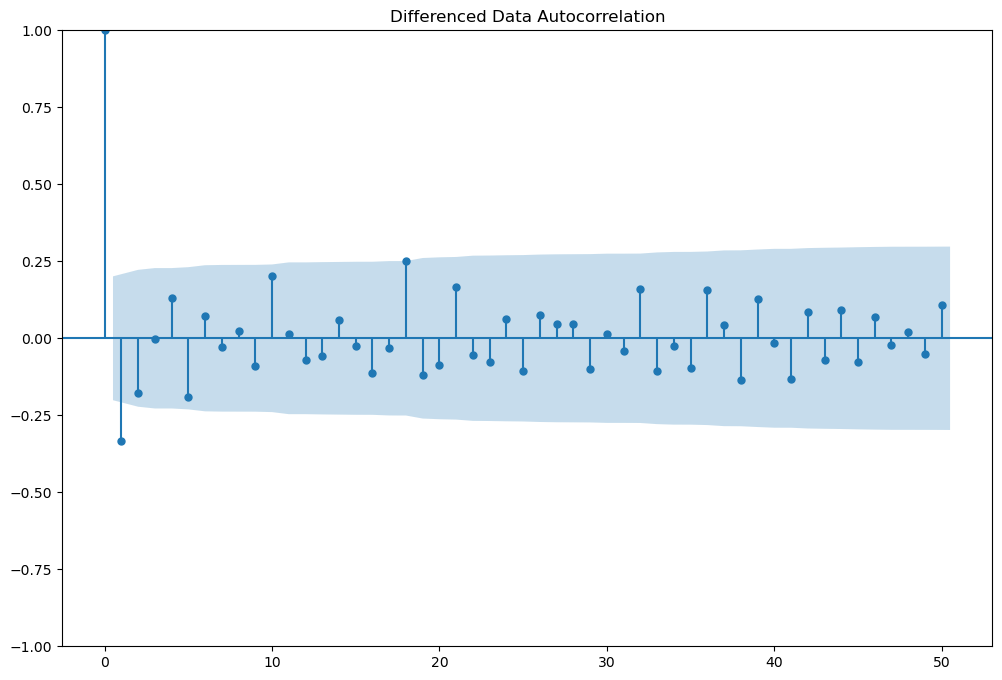

In [108]:
plot_acf(df['Rose'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()

In [109]:
import itertools
p = q = range(0, 3)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, D, q))]
print('Examples of some parameter combinations for Model...')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], model_pdq[i]))

Examples of some parameter combinations for Model...
Model: (0, 1, 1)(0, 0, 1, 6)
Model: (0, 1, 2)(0, 0, 2, 6)
Model: (1, 1, 0)(1, 0, 0, 6)
Model: (1, 1, 1)(1, 0, 1, 6)
Model: (1, 1, 2)(1, 0, 2, 6)
Model: (2, 1, 0)(2, 0, 0, 6)
Model: (2, 1, 1)(2, 0, 1, 6)
Model: (2, 1, 2)(2, 0, 2, 6)


#### SARIMA Model building to estimate best parameters 

In [110]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

,param,seasonal,AIC


In [111]:
import statsmodels.api as sm

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train['Rose'].values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 1, 0)x(0, 0, 0, 6) - AIC:673.9057047711085
SARIMA(0, 1, 0)x(0, 0, 1, 6) - AIC:615.025417919103
SARIMA(0, 1, 0)x(0, 0, 2, 6) - AIC:553.1598313509226
SARIMA(0, 1, 0)x(1, 0, 0, 6) - AIC:626.032998170077
SARIMA(0, 1, 0)x(1, 0, 1, 6) - AIC:616.382591099414


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Te

SARIMA(0, 1, 0)x(1, 0, 2, 6) - AIC:553.2255098641828
SARIMA(0, 1, 0)x(2, 0, 0, 6) - AIC:561.7338624549175
SARIMA(0, 1, 0)x(2, 0, 1, 6) - AIC:563.5479003226841


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 0)x(2, 0, 2, 6) - AIC:554.8841474684799
SARIMA(0, 1, 1)x(0, 0, 0, 6) - AIC:648.6166659997366
SARIMA(0, 1, 1)x(0, 0, 1, 6) - AIC:589.7620930695458
SARIMA(0, 1, 1)x(0, 0, 2, 6) - AIC:529.0591327047393


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Te

SARIMA(0, 1, 1)x(1, 0, 0, 6) - AIC:609.2638199010582
SARIMA(0, 1, 1)x(1, 0, 1, 6) - AIC:589.8445981010342


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(1, 0, 2, 6) - AIC:529.3008400772583
SARIMA(0, 1, 1)x(2, 0, 0, 6) - AIC:549.4534220871174


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(2, 0, 1, 6) - AIC:550.1118866013136


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(2, 0, 2, 6) - AIC:526.6572120501937
SARIMA(0, 1, 2)x(0, 0, 0, 6) - AIC:635.76787564316
SARIMA(0, 1, 2)x(0, 0, 1, 6) - AIC:576.8590043115188


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(0, 0, 2, 6) - AIC:514.6499797790534
SARIMA(0, 1, 2)x(1, 0, 0, 6) - AIC:608.2257288277601
SARIMA(0, 1, 2)x(1, 0, 1, 6) - AIC:577.8406356193004


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(1, 0, 2, 6) - AIC:515.7877962999626
SARIMA(0, 1, 2)x(2, 0, 0, 6) - AIC:547.5365002758443


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(2, 0, 1, 6) - AIC:547.7714282497726
SARIMA(0, 1, 2)x(2, 0, 2, 6) - AIC:517.5559082785252


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(0, 0, 0, 6) - AIC:670.7074639653682
SARIMA(1, 1, 0)x(0, 0, 1, 6) - AIC:611.609417643419
SARIMA(1, 1, 0)x(0, 0, 2, 6) - AIC:549.9192993104468
SARIMA(1, 1, 0)x(1, 0, 0, 6) - AIC:611.204613751838
SARIMA(1, 1, 0)x(1, 0, 1, 6) - AIC:612.9100074311858


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Te

SARIMA(1, 1, 0)x(1, 0, 2, 6) - AIC:550.0810621326181
SARIMA(1, 1, 0)x(2, 0, 0, 6) - AIC:549.8131707456467
SARIMA(1, 1, 0)x(2, 0, 1, 6) - AIC:551.3620979224248


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(2, 0, 2, 6) - AIC:544.9519230212848
SARIMA(1, 1, 1)x(0, 0, 0, 6) - AIC:646.7119409888487
SARIMA(1, 1, 1)x(0, 0, 1, 6) - AIC:589.1739341298576


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(0, 0, 2, 6) - AIC:529.2210958511641
SARIMA(1, 1, 1)x(1, 0, 0, 6) - AIC:598.2232293240402
SARIMA(1, 1, 1)x(1, 0, 1, 6) - AIC:589.4531450338661


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(1, 0, 2, 6) - AIC:529.285039892165
SARIMA(1, 1, 1)x(2, 0, 0, 6) - AIC:539.1521801862408


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(2, 0, 1, 6) - AIC:539.9039556105854


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(2, 0, 2, 6) - AIC:526.2588728443787
SARIMA(1, 1, 2)x(0, 0, 0, 6) - AIC:637.6181999390042
SARIMA(1, 1, 2)x(0, 0, 1, 6) - AIC:578.4097864443238


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(0, 0, 2, 6) - AIC:515.5168855493971
SARIMA(1, 1, 2)x(1, 0, 0, 6) - AIC:599.4790024734917


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(1, 0, 1, 6) - AIC:579.1118452124804


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(1, 0, 2, 6) - AIC:515.2304205710591
SARIMA(1, 1, 2)x(2, 0, 0, 6) - AIC:540.578041344889


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(2, 0, 1, 6) - AIC:536.3282158545329


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(2, 0, 2, 6) - AIC:501.7138315418988
SARIMA(2, 1, 0)x(0, 0, 0, 6) - AIC:654.7667108907067
SARIMA(2, 1, 0)x(0, 0, 1, 6) - AIC:605.8974613851691


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(0, 0, 2, 6) - AIC:545.5202038305009
SARIMA(2, 1, 0)x(1, 0, 0, 6) - AIC:596.1545489380939
SARIMA(2, 1, 0)x(1, 0, 1, 6) - AIC:597.5160293261653


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(1, 0, 2, 6) - AIC:545.1878059064214
SARIMA(2, 1, 0)x(2, 0, 0, 6) - AIC:536.405532800644


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(2, 0, 1, 6) - AIC:536.6280812106443
SARIMA(2, 1, 0)x(2, 0, 2, 6) - AIC:536.999197947791
SARIMA(2, 1, 1)x(0, 0, 0, 6) - AIC:647.7056081257276


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(0, 0, 1, 6) - AIC:590.0411574065007
SARIMA(2, 1, 1)x(0, 0, 2, 6) - AIC:530.074419008627
SARIMA(2, 1, 1)x(1, 0, 0, 6) - AIC:589.535344019138


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(1, 0, 1, 6) - AIC:590.2317075209106
SARIMA(2, 1, 1)x(1, 0, 2, 6) - AIC:529.9829126432423


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(2, 0, 0, 6) - AIC:529.6844541760049


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(2, 0, 1, 6) - AIC:526.2991091031851


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(2, 0, 2, 6) - AIC:531.6571291165408
SARIMA(2, 1, 2)x(0, 0, 0, 6) - AIC:639.5066737996699


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(0, 0, 1, 6) - AIC:578.0294933428374


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(0, 0, 2, 6) - AIC:517.4685395341032
SARIMA(2, 1, 2)x(1, 0, 0, 6) - AIC:591.4538252036843


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(1, 0, 1, 6) - AIC:579.0560554914871


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(1, 0, 2, 6) - AIC:513.4878648002478


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(2, 0, 0, 6) - AIC:529.0330916792946


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(2, 0, 1, 6) - AIC:528.0054414332918


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(2, 0, 2, 6) - AIC:502.40899321349974


C:\Users\subra\AppData\Local\Temp\ipykernel_46700\2980737081.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


In [112]:
SARIMA_AIC.sort_values(by=['AIC'],ascending=True).head()

,param,seasonal,AIC
53,"(1, 1, 2)","(2, 0, 2, 6)",501.713832
80,"(2, 1, 2)","(2, 0, 2, 6)",502.408993
77,"(2, 1, 2)","(1, 0, 2, 6)",513.487865
20,"(0, 1, 2)","(0, 0, 2, 6)",514.649980
50,"(1, 1, 2)","(1, 0, 2, 6)",515.230421


In [113]:
import statsmodels.api as sm

auto_SARIMA_6 = sm.tsa.statespace.SARIMAX(train['Rose'].values,
                                order=(1, 1, 2),
                                seasonal_order=(2, 0, 2, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto_SARIMA_6 = auto_SARIMA_6.fit(maxiter=1000)
print(results_auto_SARIMA_6.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   67
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 6)   Log Likelihood                -242.857
Date:                           Tue, 08 Oct 2024   AIC                            501.714
Time:                                   12:26:49   BIC                            517.168
Sample:                                        0   HQIC                           507.619
                                            - 67                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0736      0.304     -0.242      0.809      -0.670       0.523
ma.L1         -0.6227      0.352     -1.769

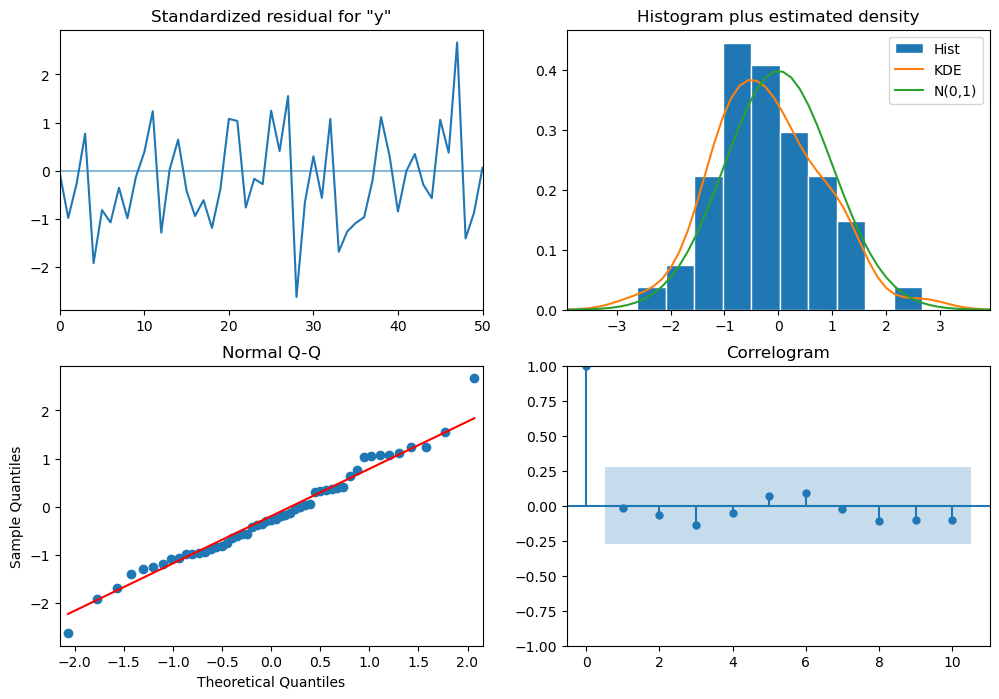

In [114]:
results_auto_SARIMA_6.plot_diagnostics()
plt.show()

## Predict on the Test Set using this model and evaluate the model.

In [115]:
predicted_auto_SARIMA_6 = results_auto_SARIMA_6.get_forecast(steps=len(test))

In [116]:
predicted_auto_SARIMA_6.summary_frame(alpha=0.05).head()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,87.442263,26.191012,36.108823,138.775703
1,91.226340,27.304996,37.709531,144.743148
2,98.182719,27.983959,43.335166,153.030272
3,97.365523,28.679832,41.154084,153.576961
4,90.902332,29.356883,33.363897,148.440766


In [117]:
rmse = mean_squared_error(test['Rose'],predicted_auto_SARIMA_6.predicted_mean,squared=False)
print(rmse)

42.30076340985104


In [118]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['SARIMA(1,1,2)(2, 0, 2, 6)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf])

resultsDf

,RMSE
"ARIMA(1,0,0)",62.608946
"ARIMA(0,1,2)",41.484815
"SARIMA(1,1,2)(2, 0, 2, 6)",42.300763


### Building the most optimum model on the Full Data.

In [119]:
full_data_model = sm.tsa.statespace.SARIMAX(df['Rose'],
                                order=(1,1,2),
                                seasonal_order=(2, 0, 2, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_full_data_model = full_data_model.fit(maxiter=1000)
print(results_full_data_model.summary())

C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                              Rose   No. Observations:                   96
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 6)   Log Likelihood                -375.438
Date:                           Tue, 08 Oct 2024   AIC                            766.877
Time:                                   12:26:50   BIC                            785.933
Sample:                                        0   HQIC                           774.517
                                            - 96                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0834      0.273     -0.306      0.760      -0.618       0.451
ma.L1         -0.6860      0.281     -2.443

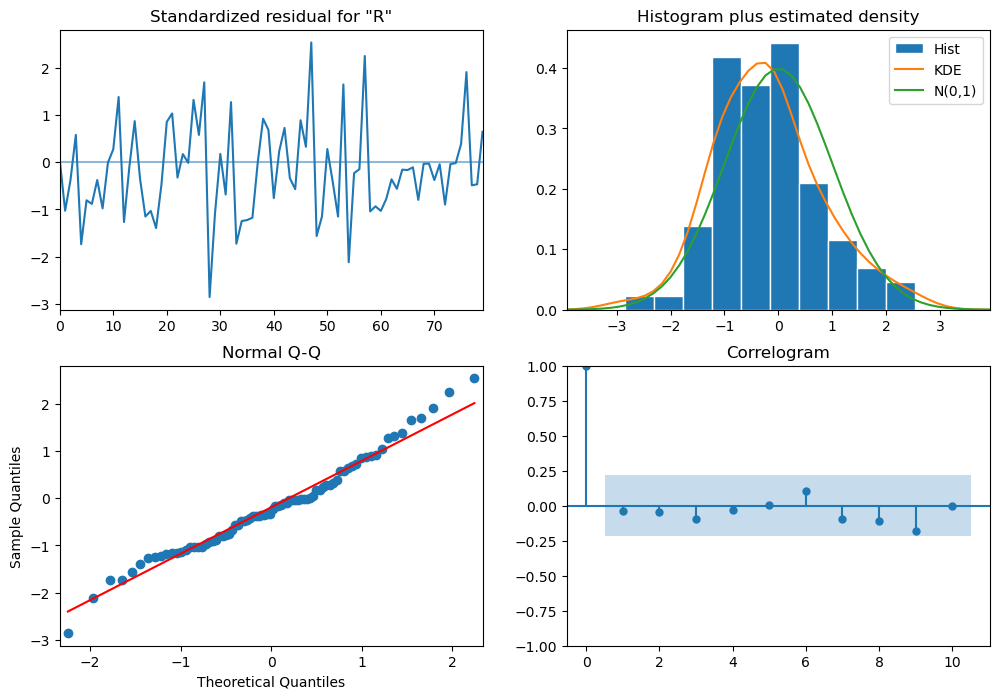

In [120]:
results_full_data_model.plot_diagnostics();

### Evaluate the model on the whole and predict 12 months into the future

In [121]:
predicted_manual_SARIMA_6_full_data = results_full_data_model.get_forecast(steps=12)

C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\subra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [122]:
predicted_manual_SARIMA_6_full_data.summary_frame(alpha=0.05).head()

Rose,mean,mean_se,mean_ci_lower,mean_ci_upper
96,50.591524,24.674697,2.230007,98.953042
97,55.514512,25.321015,5.886235,105.142789
98,58.133153,25.982504,7.208381,109.057924
99,47.253644,26.653380,-4.986021,99.493308
100,49.414822,27.309863,-4.111526,102.941170


In [123]:
rmse = mean_squared_error(df['Rose'],results_full_data_model.fittedvalues,squared=False)
print('RMSE of the Full Model',rmse)

RMSE of the Full Model 33.772868199250446


In [124]:
pred_full_manual_SARIMA_date = predicted_manual_SARIMA_6_full_data.summary_frame(alpha=0.05)

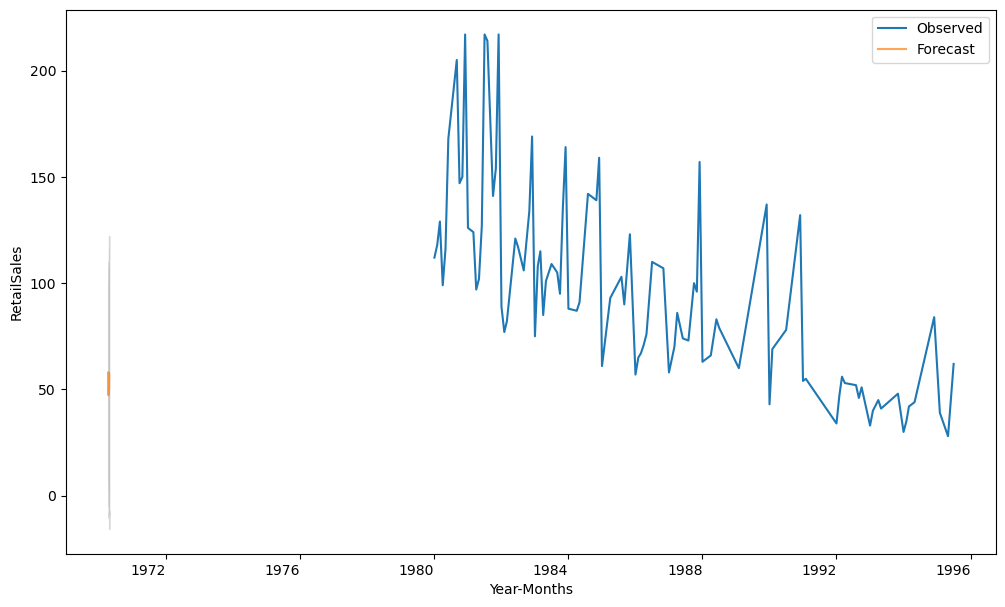

In [125]:
# plot the forecast along with the confidence band

axis = df['Rose'].plot(label='Observed')
pred_full_manual_SARIMA_date['mean'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(pred_full_manual_SARIMA_date.index, pred_full_manual_SARIMA_date['mean_ci_lower'], 
                  pred_full_manual_SARIMA_date['mean_ci_upper'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('RetailSales')
plt.legend(loc='best')
plt.show()